## 00:00:00 - Lesson 3 review

* Lesson 4 is going to take a deeper dive into training neural networks.
* Original MNIST implementation wasn't based on Arthur Samuel's idea to "altering the weight assignment to maximise performance"
* Stochasic Gradient Descent (SGD) review
  * Seven steps:
    * Init weights
    * Make prediction
    * Calculate loss
    * Calculate gradients
    * Take a step in the direction of the gradient
    * Stop when good enough

## 00:03:16 - MNIST loss function

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST_SAMPLE)
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float()  / 255
stacked_threes = torch.stack(three_tensors).float() / 255

valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_3_tens.float()/255

* Concat `x`s into a single tensor and change from list of matrices (rank 3 tensor) to list of vectors (rank 2 tensor)
  * `view` method lets you change shape of tensor.
    * `-1` is special param: make axis as big as needed to fill data.

In [2]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)

* Need a label for each `1` for threes and `0` for sevens:
  * Adds an additional unit dimension to the position passed.

In [3]:
train_y = tensor([1] * len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

* A [[PyTorch Dataset]] can be indexed into: `[i]` which should return a tuple.

In [4]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

* Create out validation set:

In [5]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28 * 28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

## 00:07:46 - Initialise params

* Need to set initially random weight for every pixel:
   * It has a variance of 1, so we can multiply by variance.

In [6]:
def init_params(size, variance=1.0):
    return (torch.randn(size)*variance).requires_grad_()

* Weights are 28*28, 1 (a flat vector of pixels)

In [7]:
weights = init_params(28*28, 1)

## 00:09:39 - Weights and biases

* `weights*pixels` isn't flexible enough, it is always equal to zero when pixels are zero (ie intercept is zeo)
  * Need the bias term in slope: `y=w*x+b`
  * Init to random number here:

In [8]:
bias = init_params(1)

* Weights and bias make up the parameters of a model
* Can calculate prediction for one image:
   * Need to first transpose them to line them up:

In [9]:
train_x[0].shape, weights.T.shape

(torch.Size([784]), torch.Size([784]))

In [10]:
(train_x[0] * weights.T).sum() + bias

tensor([13.6086], grad_fn=<AddBackward0>)

## 00:10:52 - calculate predictions with matrix multiplication

* Have to run that for every image.
  * Could run a for loop, but it would be slow and couldn't use GPU.
  * Doing that operation for multiple rows and cols is a matrix multiplication. In Python, matrix multiplication uses `@` symbol

In [11]:
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([13.6086, 18.1610, 16.9240,  ..., -6.1784,  5.6010, -5.9213],
       grad_fn=<AddBackward0>)

* That is one of the [[Two fundamental equations of a neural network]]. Activation function is the other.

## 00:14:28 - Why accuracy isn't a loss function

* Check accuuracy by checking if it's greater than 0 using broadcasting.

In [12]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True,  True,  True,  ..., False,  True, False],
        [ True,  True,  True,  ..., False,  True, False],
        [ True,  True,  True,  ..., False,  True, False],
        ...,
        [False, False, False,  ...,  True, False,  True],
        [False, False, False,  ...,  True, False,  True],
        [False, False, False,  ...,  True, False,  True]])

* `item()` returns a normal Python scalar, not a tensor.

In [13]:
corrects.float().mean().item()

0.49758008122444153

* See what happens to accuracy with small change in weights:

In [14]:
weights[0] *= 1.001

In [15]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.49758008122444153

* Since gradient is equal to rise over run: how much value of function goes up or down when divided by change in input.
  * Can write in maths: `(y_new - y_old) / (x_new - x_old)`
  * Accuracy only changes when a prediction goes from 3 to 7.
  * Small change in weights from `x_old` to `x_new` isn't likely to change prediction, so gradient is always 0.
* If gradient is 0, then step will be 0.

## 00:18:40 - A better loss function

* New function should give a better value when predictions are closer to ground truth, but never with zero gradient.

In [16]:
trgts = tensor([1, 0, 1])
prds = tensor([0.9, 0.4, 0.2])

* Using `where` function:
  * For each value, if it matches the first condition, then set the 2nd argument, else 3rd.
  * Works on tensors and runs at C/Cuda speed.
* Can then take the mean to calculate results.

In [17]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [18]:
mnist_loss(prds, trgts)

tensor(0.4333)

* If you change one of the predictions, you can see the loss improving:

In [19]:
prds = tensor([0.9, 0.4, 0.35])
mnist_loss(prds, trgts)

tensor(0.3833)

## 00:22:46 - Sigmoid

* The last problem with mnist_loss is it assumes preds are between zero and one.
  * To ensure that use [[Sigmoid]].
    * Take big numbers and turn into something between 0 and 1.

* `torch.exp(n)` is `math.e^n` 

In [20]:
torch.exp(tensor(2.)), math.e**2

(tensor(7.3891), 7.3890560989306495)

In [21]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

In [22]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

* The definition of the function isn't that useful. The shape is useful.

* Torch already has a sigmoid function.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  


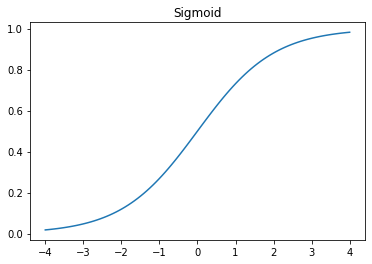

In [23]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

* Can change mnist_loss to be the same but changes to sigmoid first:

In [24]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

* Now we have a loss function with no zero gradients and it's between 0 and 1.

## 00:27:12 - Updating parameters and mini-batches

* How you would update parameters without linear algebra:
  * Loop through each image.
      * Make a prediction.
      * Calculate loss.
      * Do step.
      * Update parameters.
  * Will be really slow - a single epoch woud take a while.
* Could go faster by doing every image in the dataset with one big matrix multiplication.
   * A lot of work to update weights once.
* Comprise: do a few at a time: a [[Mini-batch]]
   * The bigger the batch size, the more "accurate" your gradient is.
   * The smaller the batch size, the more you can updated your parameters.

## 00:30:50

* PyTorch have a class called `DataLoader` that can give you data in a mini-batch.
  * Takes any Python collection and turns into iterator.

In [25]:
from fastai.data.load import DataLoader

In [26]:
col1 = range(15)
dl = DataLoader(col1, batch_size=5, shuffle=True)
list(dl)

[tensor([3, 2, 7, 8, 0]),
 tensor([ 5,  9, 13, 12, 10]),
 tensor([ 4, 11, 14,  1,  6])]

In [27]:
dl = DataLoader(col1, batch_size=10, shuffle=True)
list(dl)

[tensor([ 1,  5,  0, 14,  3,  6,  4, 10,  7,  2]),
 tensor([ 9, 12, 11,  8, 13])]

* When training model, you want collection containing independant and dependent variables (input and targets).
  * A collection that has tuples of independent and dependent variables is known as Dataset in PyTorch.

In [28]:
import string

In [29]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

* Pass that to dataloader, see it returns tuples:

In [30]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([23,  9,  3,  7, 18,  8]), ('x', 'j', 'd', 'h', 's', 'i')),
 (tensor([ 2,  1, 12, 15, 20, 24]), ('c', 'b', 'm', 'p', 'u', 'y')),
 (tensor([14, 19, 25,  6, 17, 10]), ('o', 't', 'z', 'g', 'r', 'k')),
 (tensor([22, 16,  0, 13,  5, 21]), ('w', 'q', 'a', 'n', 'f', 'v')),
 (tensor([11,  4]), ('l', 'e'))]

## 00:33:18 - Putting it all together

* The final product looks something like this:

```
for x, y, in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

In [31]:
weights = init_params((28*28), 1)
bias = init_params(1)

* `DataLoader` can be created from `Dataset`:

In [32]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [33]:
valid_dl = DataLoader(valid_dset, batch_size=256)

* Test model with a small batch

In [34]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [35]:
valid_dl = DataLoader(valid_dset, batch_size=256)

* Create a mini-batch of size 4:

In [36]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [37]:
preds = linear1(batch)
preds

tensor([ 8.6174, 19.6457, 21.7334, 11.9757], grad_fn=<AddBackward0>)

In [38]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(4.6805e-05, grad_fn=<MeanBackward0>)

* Calculate the gradients:

In [39]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784]), tensor(-6.7346e-06), tensor([-4.6796e-05]))

* Can put into a function:

In [40]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

* and test it:

In [41]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-1.3469e-05), tensor([-9.3593e-05]))

## 00:37:02 - Zeroing gradients

* If you call it twice, you get a diff value each time, which shouldn't happen with the same gradients:

In [42]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-2.0204e-05), tensor([-0.0001]))

* That's because `backward()` doesn't just calculate gradients. It adds them to stored gradients.
  * Set to zero first:
     * Note `zero_` sets to matrix of 0s inplace.

In [43]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

## 00:38:05 - Train a single epoch

* Note the use of `.data` to avoid calculating gradient during gradient descent step 

In [44]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

## 00:39:31 - SGD vs Gradient Descent

* Gradient descent doesn't have the loop part: it calculates all in one go (and is rarely used in practice):

  ```
  def train_epoch(model, lr, params):
    params = calc_grad(inputs, labels, model)
    for p in params:
        p.data -= p.grad * lr
        p.grad.zero_()
  ```

## 00:40:15 - New accuracy metric

* Since we are applying the [[Sigmoid Function]] to the predictions, the 0 position now becomes 0.5, so we decide it's a 3 if greater than 0.5

In [45]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [46]:
linear1(batch).sigmoid() > 0.5

tensor([True, True, True, True])

In [47]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

* Now a function to do for all batches in the validation set.

In [48]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [49]:
validate_epoch(linear1)

0.4803

* Since the model hasn't been trained, a 50% accuracy is what we'd expect for picking values at random.
* Let's train for one epoch:

In [50]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4859

* And more:

In [51]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.7131 0.8285 0.902 0.9312 0.9482 0.9554 0.9583 0.9612 0.9631 0.965 0.9665 0.968 0.9685 0.9694 0.9699 0.9704 0.9708 0.9708 0.9718 0.9723 

* Which is about the same accuracy as pixel similarity approach.

## 00:43:31 - Refactoring and optimisers

* We can simplify the linear model using the PyTorch class `nn.Linear` which stores the weights abd bias in an object:

In [52]:
linear_model = nn.Linear(28*28, 1)

* You can access the parameters of the model as follows:

In [53]:
w, b = linear_model.parameters()

In [54]:
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

* Can use that information to create an optimiser:

In [55]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

* Can create optimiser by passing in model params:

In [56]:
opt = BasicOptim(linear_model.parameters(), lr)

* Now to simplify training loop:

In [57]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()
        
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [58]:
train_model(linear_model, 20)

0.4932 0.7812 0.8569 0.9185 0.938 0.9507 0.9595 0.9673 0.9692 0.9712 0.9727 0.9746 0.9756 0.9775 0.979 0.9795 0.9805 0.981 0.981 0.9819 

* `fastai` provides the `SGD` class which does the same thing as `BasicOptim`

In [59]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8232 0.8486 0.916 0.9365 0.9492 0.96 0.9668 0.9692 0.9707 0.9731 0.9746 0.9766 0.978 0.979 0.9795 0.9805 0.981 0.9814 0.9814 

## 00:48:50 - DataLoaders

* DataLoaders a tiny class that stores dataloaders.
  * Does things like shuffling training dataloader, and not shuffling validation dataloader.

In [60]:
dls = DataLoaders(dl, valid_dl)

## 00:49:50 - Learning class

* Takes DataLoaders, model, optim function, loss function and metrics: does all the stuff we just did manually.

In [61]:
learn = Learner(
    dls, nn.Linear(28*28, 1), opt_func=SGD,
    loss_func=mnist_loss, metrics=batch_accuracy)

* Fit then performs train epochs:

In [62]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637084,0.282624,0.500000,00:00
1,0.467048,0.470042,0.773267,00:00
2,0.174353,0.374071,0.856931,00:00
3,0.077676,0.309243,0.917822,00:00
4,0.041960,0.280175,0.937129,00:00
5,0.027951,0.262483,0.950990,00:00
6,0.022152,0.250253,0.960396,00:00
7,0.019541,0.241204,0.966832,00:00
8,0.018195,0.234096,0.968812,00:00
9,0.017375,0.228241,0.970792,00:00


## 00:51:09 - Adding non-linearity

* What we've done so far is created a linear function. That's not a neural network.
  * A neural network requires a non-linearity to handle more complex task.
* One thing we can add is a function that replaces negative numbers with 0.

In [63]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

* `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; parameters initially randomly initialised like the previous section.
  * Since `w1` has 30 output activations, `w2` must have 30 input activations.

In [64]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

* The `res.max(tensor(0.0))` is called a [[Rectified Linear Unit [[ReLU]].
  * Also available in PyTorch as `F.relu`:

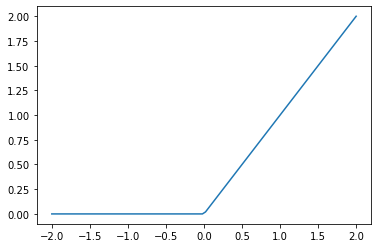

In [65]:
plot_function(F.relu)

* ReLU is an example of a a lot of things sound complicated and "scary" in Deep Learning, but are quite simple at their core.

## 00:53:24 - Why non-linear activation like RelU?

* Without a non-linear activation function, 2 linear layers could simply be rewritten as a single linear layer.
  * With a non-linear, you should be able to approximate any arbitrary function according to Universal Approximation Theory.
  
## 00:55:03 - On Deep Learning's simplicity

* One of the challenges beginner's have: there isn't anything more to neural networks than the function above.
  * Some tricks to use less parameters etc
  * Most of it is just performance tweaks.
  
## 00:55:54 - Refactoring and functional composition

* [[Function Composition]] is when you take the result from one function and pass into the next.
  * A [[Neural Network]] is just [[Function Composition]] of linear layers and activation functions.
* PyTorch provides a tool for functional composition called `nn.Sequential`:

In [66]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

## 00:57:08 - Question: does ReLU cause many zero gradients?

* Yes, it does. However, they won't be zero for every image. And it definitely won't be for every minibatch.
  * It is still a waste of computation having "inactive neurons".
    * There is an approach that will show you how many dead neurons in the network that is shown later in the course.
  * Leaky ReLU is one alternative approach: `res.max(0.0001)`

## 00:59:27 - Training neural network

In [67]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

* Note that as layers get deeper, you tend to have to have smaller learning rates as they tend to be "bumpier".

In [68]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.354369,0.616766,0.500000,00:00
1,0.161114,0.465830,0.787624,00:00
2,0.086780,0.337809,0.913861,00:00
3,0.055466,0.294628,0.943069,00:00
4,0.041220,0.273913,0.961386,00:00
5,0.034107,0.261356,0.969307,00:00
6,0.030110,0.252680,0.971287,00:00
7,0.027568,0.246107,0.972277,00:00
8,0.025765,0.240831,0.973762,00:00
9,0.024386,0.236410,0.975743,00:00


* Can use `recorder` to peer inside learner.
  * `values` can be used to plot accuracy over training:

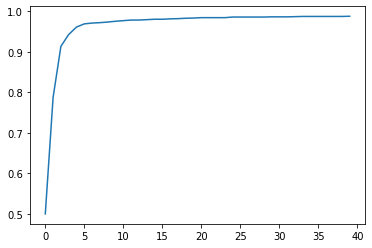

In [69]:
plt.plot(L(learn.recorder.values).itemgot(2));

and can get final accuracy:

In [70]:
learn.recorder.values[-1][2]

0.9881188273429871

* We now have a function that can solve any problem to any level of accuracy, if we can find the right parameters.

## 01:01:53 - How can we use the learner to visual the model?

* Can use `learn.model` to see the model:

In [71]:
m = learn.model
m

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [72]:
w,b = m[0].parameters()

In [73]:
w.shape

torch.Size([30, 784])

In [74]:
w2, b2 = m[2].parameters()

In [75]:
w2.shape

torch.Size([1, 30])

<AxesSubplot:>

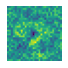

In [76]:
show_image(w[0].view((28, 28)))

## 01:05:30 - Train models with approach from Lesson 1

In [77]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                   loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.082512,0.010295,0.996075,00:18


* Nearly 100% accuracy! Clearly the tricks help.

## 01:06:20 - Jargon recap

* `ReLU` - function that convert negative numbers into 0.
* `mini-batch` - A couple of inputs and labels.
* `forward pass` - Applying the model to your inputs and calculting loss.
* `loss` - Value that tells you how model is doing.
* `gradient` - Derivate of loss with respect to parameters of the model.
* `backward pass` - Compute gradients of the loss with respect to model params.
* `gradient descent` - Take a step in directions opposite to gradients to make model params better.
* `learning rate` - Size of step we take when applying SGD to update params of model.

* `parameters` - numbers we're learning
* `activations` - numbers we're calculating 

* Tensor ranks:
  * rank zero: scalar
  * rank one: vector
  * rank two: matrix

## 01:09:43 - Pet breeds image classification

* How do we understand the data in our data set?
  * Can use ls to see inside dataset.

In [78]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [79]:
# For conveinence so that the base path is hidden when printing.
Path.BASE_PATH = path

In [80]:
path.ls()

(#2) [Path('images'),Path('annotations')]

* Can take a look at the images directory:

In [81]:
(path/"images").ls()

(#7393) [Path('images/beagle_115.jpg'),Path('images/boxer_18.jpg'),Path('images/Maine_Coon_157.jpg'),Path('images/scottish_terrier_28.jpg'),Path('images/english_setter_6.jpg'),Path('images/american_pit_bull_terrier_79.jpg'),Path('images/boxer_128.jpg'),Path('images/Persian_265.jpg'),Path('images/Maine_Coon_182.jpg'),Path('images/keeshond_89.jpg')...]

## 01:12:08 - L class revisited

* Methods in fastai that would return a list generally return an `L` class.
* `L` has a number of enhanced:
  * When it prints, it tells you how many items in the list and truncates the output.

## 01:12:50 - Generating labels with regex

* Since we know that dogs labels first character is lower case, we can use that to filter.
* Will use regex for filtering. To start, let's build the regex on one example:

In [82]:
fname = (path/"images").ls()[0]

In [83]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['beagle']

* In Python, `r` before a string says: don't treat `\` special.
* Can use that to create a DataBlock of breeds:

In [84]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path/"images")

## 01:17:11 - Presizing

* These 2 lines are performance a `fastai` data augmentation strategy called "presizing":

    ```
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
    ```

  * Resize to a reasonable size with cropping, then perform resizing for each batch.
  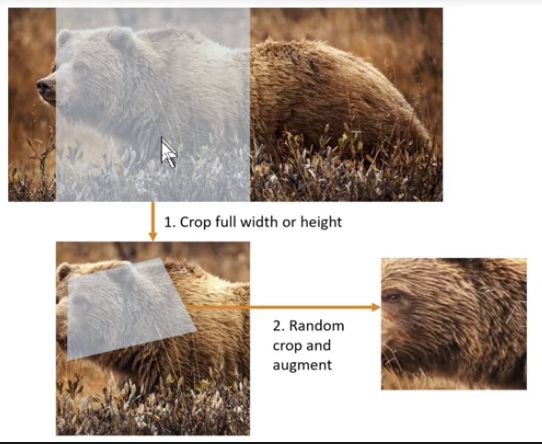

* 2 advantage to this:
  1. Because 1st step creates something square, 2nd step can happen on GPU.
  2. Normally doing zoom, rotate and warp is destructive to image and is slow.
     * Fastai keeps track of coordinate transforms, then performs them all in one go.

## 01:21:48 - Are blocks in DataBlocks an ordered list

* Yes, it's an ordered list: independant and dependant variable.

## 01:22:51 - Checking and debugging a DataBlock

* Want to check DataBlocks are working correctly by visualing examples:

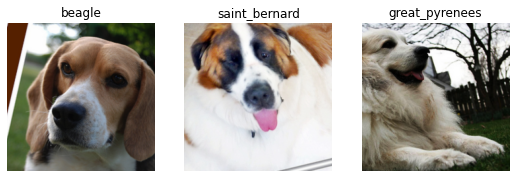

In [85]:
dls.show_batch(nrows=1, ncols=3)

* Can add `unique=True` to show the same image with different augementations:

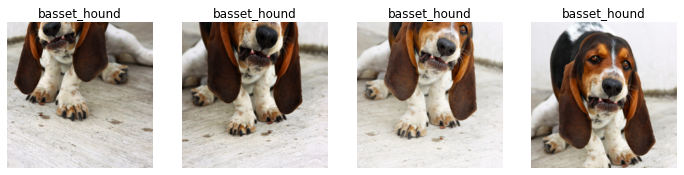

In [86]:
dls.show_batch(nrows=1, ncols=4, unique=True)

* Call `summary` on DataBlock to tell you everything that's happening:

In [87]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/basset_hound_43.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/basset_hound_43.jpg
    applying partial gives
      basset_hound
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(14)

Final sample: (PILImage mode=RGB size=333x500, TensorCategory(14))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up afte

## 01:24:39 - How does presize work if image is smaller than resize value

* By default uses Crop. If image is smaller than resize value then it will stretch or zoom.

## 01:25:46 - Data cleaning?

* A lot of people say do data cleaning before training model.
  * Fastai don't recommend that.
  * Let the model show problems with your data.
  * Once you have working datablock, then you can train model then use the ImageClassifierCleaner to clean data and retrain.

## 01:26:44 - fastai auto selecting loss function

* When we create a `cnn_learner`, we don't have to pass a loss function as fastai picks one for you.
  * Can view the loss_func picked with `learn.loss_func`

In [88]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [89]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [90]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.530561,0.351941,0.110961,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.501460,0.278948,0.090663,01:02
1,0.312027,0.230514,0.081867,01:02


## 01:27:38 - CrossEntropyLoss

* Cross entropy loss is similar to `mnist_loss` from earlier, but has 2 benefits:
  * The `torch.where` only works when you have a [[Binary outcome]].
  * CrossEntropyLoss works when you have more than 2 categories.

## 01:28:48 - Why build a model before building the model?

* We train a model then clean, then retrain on a cleaner dataset.

## 01:29:52 - CrossEntropyLoss (cont)

* To understand CrossEntropyLoss we can first grab a single batch of data: 

In [91]:
x, y = dls.one_batch()

* The dependant variables is an integer from 0 - 36 which can be indexed into vocab:

In [92]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [93]:
y

TensorCategory([18,  8,  2,  3, 20, 23,  0, 16, 33, 34, 36, 33, 23,  1, 13, 28,  8,  9,
        33, 27,  0, 29, 31,  9, 28, 33, 32, 34, 19, 13, 16, 27,  1,  1, 34, 21,
         0,  0, 24,  1, 36, 30, 30, 27, 36, 15, 26,  6,  8,  1,  4, 29,  6,  3,
        20, 17, 28, 12, 24, 12,  8, 13, 34, 34], device='cuda:0')

* Now can view the predictions:

In [94]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.0729e-08, 4.3481e-07, 6.9428e-08, 9.6537e-05, 6.7323e-08, 3.0598e-07,
        1.4778e-07, 4.1984e-07, 5.5789e-07, 1.8727e-07, 6.8065e-07, 9.1549e-07,
        4.1090e-08, 1.8019e-06, 2.1134e-07, 5.7010e-09, 9.7951e-08, 8.2589e-07,
        9.7550e-01, 1.9526e-05, 5.3416e-07, 8.1457e-07, 5.0175e-05, 2.5848e-06,
        1.2259e-07, 7.9796e-07, 1.6931e-07, 4.4172e-03, 7.4759e-08, 1.2960e-07,
        1.2986e-06, 2.1392e-07, 1.9848e-02, 1.5104e-08, 1.6935e-05, 3.3762e-05,
        6.8006e-07])

* Can see the preds add up to one:

In [95]:
preds[0].sum()

tensor(1.0000)

## 01:32:38 - Softmax

* To make sets of predictions like this that are probability-like, we use Softmax.
* Softmax is "basically an extension of Sigmoid"
* What if we wanted more categories than just 2?

In [96]:
torch.random.manual_seed(42);

* Creating random numbers with standard deviation of 2 to resemble a model with 2 activations (is 3 or is 7)

In [97]:
acts = torch.randn((6, 2)) * 2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

* If we simply apply Sigmoid, we don't get something that's probability like ie sums to 1.

In [98]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

* What we care about is the *relative* confidence of being a "3 vs a "7".
  * So we can calculate the relative difference between activations and take the sigmoid of that:

In [99]:
diff = acts[:,0]-acts[:,1]
diff

tensor([ 0.4158,  0.0083, -1.8731,  5.6924,  0.3886, -0.5489])

In [100]:
diff.sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

* To get 2 columns, we could subtract 1-value from the second column (prob of being 7):

In [101]:
torch.stack([diff.sigmoid(), 1-diff.sigmoid()], dim=1)

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

* How do we do this for more than 2 cols?
  * We can use the [[Softmax Function]]

In [102]:
def softmax(x):
    return exp(x) / exp(x).sum(dim=1, keepdim=True)

* Softmax is: $$\frac{e^x}{\sum\limits_{i=1}^{N}e^{x_i}}$$
  * The Exponential function (exp) is defined as: `e**x`.
    * `e` is a special number approximately equal to 2.718. It increases rapidly.
* Can see `softmax` returns same value as `sigmoid` for the first column:

In [103]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

* In the multi-category case, softmax would look something like:

In [104]:
outputs = tensor([0.02, -2.49, 1.25])
outputs

tensor([ 0.0200, -2.4900,  1.2500])

In [105]:
exp = outputs.exp()
exp

tensor([1.0202, 0.0829, 3.4903])

In [106]:
softmax = torch.softmax(outputs, dim=0)
softmax

tensor([0.2221, 0.0180, 0.7599])

* Softmax tends to "amplify" a single result.
  * Which may not be what you always want.
  * An alternative is multiple binary values with Sigmoid.

## 01:40:38 - Log likelihood

* We could take a similar approach to the `mnist_loss` function by replacing `torch.where` with indexing:

```
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()
```

In [107]:
targ = tensor([0,1,0,1,1,0])

In [108]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

* then for each of the `targ` we can use that column of `sm_acts` using tensor indexing.
  * Here we are requesting rows between 0 and 6 and columns that match the targs:

In [109]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [110]:
df = pd.DataFrame(sm_acts, columns=['3', '7'])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
df

,3,7,targ,idx,loss
0,0.602469,0.397531,0,0,0.602469
1,0.502065,0.497935,1,1,0.497935
2,0.133188,0.866811,0,2,0.133188
3,0.996640,0.003360,1,3,0.003360
4,0.595949,0.404051,1,4,0.404051
5,0.366118,0.633882,0,5,0.366118


* This works with more than 2 columns
* PyTorch provides a function that does that same thing as `sm_acts[range(n), targ]`
  * Note: it takes a negative, because the log taken after gives us negative numbers, called `nll_loss` (NLL stands for *negative log likelihood*):

In [111]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [112]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

* Confusingly, negative log likelihood doesn't take the log.

## 01:44:31 - Logs

* It works as a loss function, but can be better.
  * Using probabilities, it cannot be smaller than zero, or greater than one
  * Model will not care it it's predicting 0.99 or 0.999
    * But the error if there's 1000 things, the first means 10 thing is wrong, the 2nd means 1 thing are wrong.
    * Want to translate predictions as being between -infinity and infinity.
  * There is a function in Math that does it: the logarithm: 

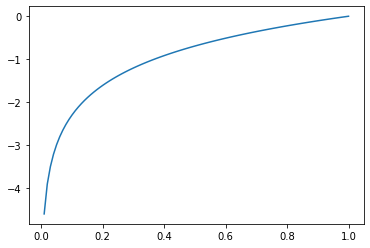

In [113]:
plot_function(torch.log, min=0, max=1)

In [114]:
torch.log(tensor(0.)), torch.log(tensor(0.2)), torch.log(tensor(0.99)), torch.log(tensor(0.999))

(tensor(-inf), tensor(-1.6094), tensor(-0.0101), tensor(-0.0010))

* The logarithm has this identity:

```
y = b**a
a = log(y, b)
```
* In this case, `log(y, b)` returns `log y base b`.
  * PyTorch doesn't define `log` this way. It uses special number $e$ (2.718...) as the base

* This relationship is one of the most important things about logarithms:

```
log(a*b) = log(a) + log(b)
```

* Because `a*b` can get big or small, that the precision in computers floating point math can get out of hand.
  * But, adding doesn't.

## 01:47:54 - Negative Log Likelihood



* If you take the softmax, then take the log, then pass to `nll_loss`, it's called `cross entropy loss`

In [115]:
loss_func = nn.CrossEntropyLoss()
loss_func(acts, targ)

tensor(1.8045)

* In PyTorch, you can usually use `nn.Class` version or `F.func_name`. Usually the class version if preferred:

In [116]:
F.cross_entropy(acts, targ)

tensor(1.8045)

* Errata: at 01:49:56: says "camel case" name where he means "snake case".

* It returns a single number as that's required for the loss function, but the individual values are available passing `reduction=none`:

In [117]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## 01:51:46 - Data ethics and mask efficiency

* Jeremy pointed at that masks are likely very effective.
  * Found himself as face of global advocacy campaign.
  * Found data around masks was misunderstood.
* Role of data scientist: to understand data and do something about it.
* What was clear: people weren't convinced by science, especially when WHO and CDC are saying the opposite.
* Put together a team to review the evidence and wrote [this](https://www.pnas.org/content/118/4/e2014564118) paper.
* Knowing the data isn't effective unless you can communicate to decision makers.